<a href="https://colab.research.google.com/github/anselvelazquez/PoC_Datum_Chatbot_MS/blob/main/PoC_DATUM_CHATBOT_OFICIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. LIBRERÍAS
*Descarga de todas las librerías necesarias para la demo*

In [1]:
!pip install -q -U transformers==4.40.2
!pip install -q -U accelerate==0.30.1
!pip install -q -U bitsandbytes==0.43.1
!pip install -q -U huggingface_hub==0.23.0
!pip install -q -U langchain==0.1.2
!pip install -q -U pypdf==4.2.0
!pip install -q -U sentence-transformers==2.7.0
!pip install -q -U faiss-gpu==1.7.2
!pip install gradio
!pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.6/803.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [6]:
import huggingface_hub as hf_hub

hf_hub.login()

# 2. ANÁLISIS GPU
*Código para checkear qué GPU/CPU estamos utilizando*

In [4]:
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig, BitsAndBytesConfig
import torch
from langchain.llms import HuggingFacePipeline

from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import HuggingFaceHub
from langchain.vectorstores import Chroma
from langchain.chains import ConversationalRetrievalChain

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Device:", device)
if device == 'cuda':
    print(torch.cuda.get_device_name(0))

Device: cuda
Tesla T4


# 3. LLM
*Descarga e implementación del LLM: [Mistral-7B]("https://mistral.ai/news/announcing-mistral-7b/")*

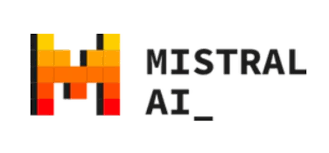

In [7]:
origin_model_path = "mistralai/Mistral-7B-Instruct-v0.1"
model_path = "filipealmeida/Mistral-7B-Instruct-v0.1-sharded"
bnb_config = BitsAndBytesConfig \
              (
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.bfloat16,
              )
model = AutoModelForCausalLM.from_pretrained (model_path, trust_remote_code=True,
                                              quantization_config=bnb_config,
                                              device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(origin_model_path)

text_generation_pipeline = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=300,
    #temperature = 0.3,
    temperature = 0.00001,
    do_sample=True,
)
mistral_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

# 4. MODELO TRADUCTOR
*Mistral 7B funciona mejor en inglés por lo que este modelo nos ayudara a preguntar al LLM.
Modelo: Opus-mt-es-en*

In [8]:
from transformers import MarianMTModel, MarianTokenizer

model_name = 'Helsinki-NLP/opus-mt-es-en'
tokenizer_traductor = MarianTokenizer.from_pretrained(model_name)
model_traductor = MarianMTModel.from_pretrained(model_name)

def traducir(texto):
    inputs = tokenizer_traductor.encode(texto, return_tensors="pt", max_length=512, truncation=True)

    translated = model_traductor.generate(inputs, max_length=512, num_beams=4, early_stopping=True)

    traduccion = tokenizer_traductor.decode(translated[0], skip_special_tokens=True)
    return traduccion

# Ejemplo de uso
texto_en_espanol = "Eres un asistente de Inteligencia Artifical. Responde siempre en español. Si no sabes responder a alguna pregunta, simplemente di que no sabes contestar."
texto_en_ingles = traducir(texto_en_espanol)
print(f"Texto en español: {texto_en_espanol}")
print(f"Texto en inglés: {texto_en_ingles}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Texto en español: Eres un asistente de Inteligencia Artifical. Responde siempre en español. Si no sabes responder a alguna pregunta, simplemente di que no sabes contestar.
Texto en inglés: You're an AI assistant. Always answer in Spanish. If you don't know how to answer any questions, just say you can't answer them.


In [29]:
import re
from transformers import MarianMTModel, MarianTokenizer


model_name_2 = 'Helsinki-NLP/opus-mt-en-es'
tokenizer_traductor_2 = MarianTokenizer.from_pretrained(model_name_2)
model_traductor_2 = MarianMTModel.from_pretrained(model_name_2)

def traducir_2(texto):
    # Encuentra todos los términos técnicos usando una expresión regular
    terminos_tecnicos = re.findall(r'\b(?:t|g|gf)_[a-zA-Z_]+\b', texto)
    #print(f"Términos técnicos encontrados: {terminos_tecnicos}")

    # Mapea los términos técnicos a marcadores temporales únicos
    terminos_marcadores = {f"TERM_{i}_UNIQUESTRING": termino for i, termino in enumerate(terminos_tecnicos)}

    # Reemplaza los términos técnicos con marcadores temporales
    for marcador, termino in terminos_marcadores.items():
        texto = texto.replace(termino, marcador)
    #print(f"Texto con marcadores temporales: {texto}")

    # Traduce el texto con el modelo MarianMT
    inputs_2 = tokenizer_traductor_2.encode(texto, return_tensors="pt", max_length=512, truncation=True)
    translated_2 = model_traductor_2.generate(inputs_2, max_length=512, num_beams=4, early_stopping=True)
    traduccion_2 = tokenizer_traductor_2.decode(translated_2[0], skip_special_tokens=True)
    #print(f"Texto traducido: {traduccion_2}")

    # Restaura los términos técnicos
    for marcador, termino in terminos_marcadores.items():
        traduccion_2 = traduccion_2.replace(marcador, termino)

    return traduccion_2


# Ejemplo de uso
texto_en_ingles = "You're an AI assistant. Always answer in Spanish. If you don't know how to answer any questions, just say you can't answer them."
texto_en_espanol = traducir_2(texto_en_ingles)

print(f"Texto en inglés: {texto_en_ingles}")
print(f"Texto en español: {texto_en_espanol}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Texto en inglés: You're an AI assistant. Always answer in Spanish. If you don't know how to answer any questions, just say you can't answer them.
Texto en español: Siempre respondes en español. Si no sabes cómo responder a ninguna pregunta, solo di que no puedes responderla.


# 5. PRUEBA CONVERSACIONAL LLM+TRADUCTOR

In [10]:
from textwrap import fill
from langchain.prompts import PromptTemplate

template = """
[INST] <>
You're an AI assistant. Always answer in Spanish. If you don't know how to answer any questions, just say you can't answer them."
<>

{text} [/INST]
"""

prompt = PromptTemplate(
    input_variables=["text"],
    template=template,
)

text = "Explica brevemente lo que es la inteligencia artificial"
text_en = traducir(text)
result = mistral_llm(prompt.format(text=text_en))
print(fill(result.strip(), width=100))

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


La inteligencia artificia (IA) es la capacidad de un sistema o una máquina para realizar tareas que
normalmente se asignan a ser realizadas por humanos. Esto se logra mediante el uso de algoritmos y
otras herramientas de computación para simular el pensamiento humano y permitir a la máquina
realizar acciones en base a datos y percepciones. La IA tiene varios subcampos, incluyendo la
inteligencia adaptativa, la inteligencia fuzzy y la inteligencia de aprendizaje profundo.


# 6. RAG

In [11]:
from langchain_community.document_loaders.csv_loader import CSVLoader

csv_file_path = '/content/DATUM_3.csv'
loader = CSVLoader(file_path=csv_file_path,csv_args = {
                "delimiter": ';',
#                 "quotechar": csv.Dialect.quotechar,
            })
data = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
chunked_docs  = text_splitter.split_documents(data)
embeddings = HuggingFaceEmbeddings()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [12]:
from langchain.vectorstores import FAISS
db = FAISS.from_documents(chunked_docs,
                          HuggingFaceEmbeddings(model_name='sentence-transformers/all-mpnet-base-v2'))


# Connect query to FAISS index using a retriever
retriever = db.as_retriever(
    search_type="similarity",
    search_kwargs={'k': 4}
)

# 7. IMPLEMENTACIÓN CHATBOT

In [30]:
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from textwrap import fill

prompt_template = """
[INST] <>
You are the chatbot of a famous Spanish bank called BBVA. If you don’t know how to answer any questions, just say you can’t answer them.
<>

{context}

Please provide a direct answer to the following question: {question} [/INST]
"""

prompt = PromptTemplate(template=prompt_template, input_variables=["context", "question"])
Chain_pdf = RetrievalQA.from_chain_type(
    llm=mistral_llm,
    chain_type="stuff",
    retriever=retriever,
    chain_type_kwargs={"prompt": prompt},
)
#query = "Hay algún campo donde pueda consultar el nombre completo de un cliente?"
query = "Hay algún campo que nos indique el número total de coches de un cliente?"
query_en = traducir(query)
result = Chain_pdf.invoke(query_en)
print(fill(traducir_2(result['result'].strip()), width=100))

Sí, hay un campo en el cuadro `t_kbtq_customer_info` llamado `gf_total_cars_number` que almacena el
número total de automóviles propiedad de un cliente.


In [32]:
import sys
chat_history = []
query = input('Prompt: ')
query_en = traducir(query)
result = Chain_pdf.invoke(query_en)
print(fill(traducir_2(result['result'].strip()), width=100))

Prompt: Hay algún campo que nos indique el número de teléfono de un cliente?
Sí, hay un campo en la tabla `t_kbtq_customer_contact` y `t_kbtq_customer_rel_person` llamado
`gf_phone_id` que almacena el número de teléfono del cliente como método de contacto.


In [33]:
import sys
chat_history = []
query = input('Prompt: ')
query_en = traducir(query)
result = Chain_pdf.invoke(query_en)
print(fill(traducir_2(result['result'].strip()), width=100))

Prompt: Dime algunas tablas en las que pueda encontrar el identificador de un cliente
Puede encontrar el identificador de un cliente en las siguientes tablas: * tabla
`t_ksag_members_relation` con campo `g_customer_id` * tabla `t_kbtq_customer_rel_customer` con campo
`g_related_customer_id`


# 8. DEMO

In [34]:
import gradio as gr
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA


# build conversational retrieval chain with memory (rag) using langchain
def create_conversation(query: str, chat_history: list) -> tuple:
    try:

        memory = ConversationBufferMemory(
            memory_key='chat_history',
            return_messages=False
        )

        qa_chain = ConversationalRetrievalChain.from_llm(
            llm=mistral_llm,
            retriever=db.as_retriever(
                                search_type="similarity",
                                search_kwargs={'k': 4}
            ),
            memory=memory,
            get_chat_history=lambda h: h,
        )
        query_en = traducir(query)
        result = Chain_pdf.invoke(query_en)
        print(fill(traducir_2(result['result'].strip()), width=100))
        chat_history.append((query, traducir_2(result['result'])))
        return '', chat_history


    except Exception as e:
        chat_history.append((query, e))
        return '', chat_history


with gr.Blocks() as demo:

    chatbot = gr.Chatbot(label='DATUM chatbot by Management Solutions')
    msg = gr.Textbox()
    clear = gr.ClearButton([msg, chatbot])

    msg.submit(create_conversation, [msg, chatbot], [msg, chatbot])

demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://90db503aedd9e90516.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Sí, hay un campo en la tabla `t_kbtq_customer_contact` y `t_kbtq_customer_rel_person` llamado
`gf_phone_id` que almacena el número de teléfono del cliente como método de contacto.
Sí, hay un campo en el cuadro `t_kbtq_customer_info` llamado `gf_total_cars_number` que almacena el
número total de automóviles propiedad de un cliente.
Sí, hay un campo en la tabla `t_kbtq_customer_info` donde se puede comprobar el nombre completo de
un cliente. El campo se llama `gf_customer_complete_name`.
Puede encontrar información sobre el sexo o género de una persona en los campos "gf\_gender\_type"
en las tablas "t\_kbtq\_nclustomer\_info", "t\_kbtq\_nclustomer\_info\_err", y
"t\_kbtq\_nclustomer\_info\_del".
Puede encontrar información sobre el sexo o género de una persona en los campos "gf\_gender\_type"
en las tablas "t\_kbtq\_nclustomer\_info", "t\_kbtq\_nclustomer\_info\_err", y
"t\_kbtq\_nclustomer\_info\_del".
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860